## Hyperparameter tuning via Optuna

### Being a binary model this notebook will be limited to predicting one class 1 or 0, yes or no.
### Here I will be predicting if a cell received a treatment or not

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly
import seaborn as sns
import toml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

sys.path.append("..")
from MLP_utils.parameters import Parameters
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc

import pyarrow.parquet as pq

from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

from utils.utils import df_stats
from MLP_utils.utils import parameter_set

In [2]:
# Import Data
# set data file path under pathlib path for multi-system use
file_path = Path("../../Extracted_Features_(CSV_files)/feature_df_sc_norm.parquet")

df = pq.read_table(file_path).to_pandas()
# df = pd.read_csv(file_path, engine="pyarrow")

In [3]:
data = Path("MLP_utils/config.toml")
config = toml.load(data)
params = Parameters()
params = parameter_set(params, config)

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [4]:
df

,Metadata_cell_type,Metadata_Well,Metadata_number_of_singlecells,Metadata_incubation inducer (h),Metadata_inhibitor,Metadata_inhibitor_concentration,Metadata_inhibitor_concentration_unit,Metadata_inducer1,Metadata_inducer1_concentration,Metadata_inducer1_concentration_unit,...,Nuclei_Texture_Variance_CorrPM_3_00_256,Nuclei_Texture_Variance_CorrPM_3_01_256,Nuclei_Texture_Variance_CorrPM_3_02_256,Nuclei_Texture_Variance_CorrPM_3_03_256,Metadata_Treatment,Metadata_Dose,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,twob_Metadata_Treatment_Dose_Inhibitor_Dose,threeb_Metadata_Treatment_Dose_Inhibitor_Dose,fourb_Metadata_Treatment_Dose_Inhibitor_Dose
0,SH-SY5Y,B13,3765,6,Media ctr,0.0,None,media ctr,0.0,None,...,0.099225,0.096054,0.110432,0.107764,media ctr,0,media ctr_0_Media ctr_0.0,media ctr_Media ctr_0.0__0,media ctr__0__Media ctr_0.0,media ctr__0__Media ctr__0.0
1,SH-SY5Y,B13,3765,6,Media ctr,0.0,None,media ctr,0.0,None,...,0.020683,0.016122,0.012990,0.013631,media ctr,0,media ctr_0_Media ctr_0.0,media ctr_Media ctr_0.0__0,media ctr__0__Media ctr_0.0,media ctr__0__Media ctr__0.0
2,SH-SY5Y,B13,3765,6,Media ctr,0.0,None,media ctr,0.0,None,...,0.027519,0.045982,0.037653,0.017281,media ctr,0,media ctr_0_Media ctr_0.0,media ctr_Media ctr_0.0__0,media ctr__0__Media ctr_0.0,media ctr__0__Media ctr__0.0
3,SH-SY5Y,B13,3765,6,Media ctr,0.0,None,media ctr,0.0,None,...,-0.002945,0.000293,0.008048,-0.002151,media ctr,0,media ctr_0_Media ctr_0.0,media ctr_Media ctr_0.0__0,media ctr__0__Media ctr_0.0,media ctr__0__Media ctr__0.0
4,SH-SY5Y,B13,3765,6,Media ctr,0.0,None,media ctr,0.0,None,...,0.016846,0.006499,0.014114,0.026206,media ctr,0,media ctr_0_Media ctr_0.0,media ctr_Media ctr_0.0__0,media ctr__0__Media ctr_0.0,media ctr__0__Media ctr__0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597897,SH-SY5Y,O23,3555,6,Media ctr,0.0,None,media ctr,0.0,None,...,-0.024370,-0.033577,-0.033811,-0.028148,media ctr,0,media ctr_0_Media ctr_0.0,media ctr_Media ctr_0.0__0,media ctr__0__Media ctr_0.0,media ctr__0__Media ctr__0.0
597898,SH-SY5Y,O23,3555,6,Media ctr,0.0,None,media ctr,0.0,None,...,-0.049855,-0.048752,-0.050176,-0.049417,media ctr,0,media ctr_0_Media ctr_0.0,media ctr_Media ctr_0.0__0,media ctr__0__Media ctr_0.0,media ctr__0__Media ctr__0.0
597899,SH-SY5Y,O23,3555,6,Media ctr,0.0,None,media ctr,0.0,None,...,-0.027676,-0.024066,-0.026279,-0.027050,media ctr,0,media ctr_0_Media ctr_0.0,media ctr_Media ctr_0.0__0,media ctr__0__Media ctr_0.0,media ctr__0__Media ctr__0.0
597900,SH-SY5Y,O23,3555,6,Media ctr,0.0,None,media ctr,0.0,None,...,0.308702,0.309290,0.311365,0.309627,media ctr,0,media ctr_0_Media ctr_0.0,media ctr_Media ctr_0.0__0,media ctr__0__Media ctr_0.0,media ctr__0__Media ctr__0.0


In [5]:
# Combine treatment with dosage to be able to discern treatments with different doses as a different condition
# Combine treatment and dose
# df = df.assign(
# Metadata_Treatment_and_Dose=lambda x: df["Metadata_treatment"]
# + "_"
# + df["Metadata_dose"]
# )

# print("Unique Catagories are:")
# print(df["Metadata_Treatment_and_Dose"].unique())

# Generate df specific to analysis and model
# df = df.query(
# "Metadata_Treatment_and_Dose == 'LPS_10µg/ml'| Metadata_Treatment_and_Dose == 'Media only_0' | Metadata_Treatment_and_Dose == 'Disulfiram_2.5µM'"
# )
# for binary classification testing
# df = df.query(
#     "Metadata_Treatment_and_Dose == 'LPS_10µg/ml'| Metadata_Treatment_and_Dose == 'Media only_0'"
# )
# print("Selected Catagories are:")
# print(df["Metadata_Treatment_and_Dose"].unique())
# Drop na and reindex accordingly
# df = df.dropna()
# df = df.reset_index(drop=True)

# Check for Nans again
# df_stats(df)

# Understand categorical data such as treatment and dosing
# df[["Metadata_Treatment_and_Dose"]].drop_duplicates()

if params.DATA_SUBSET_OPTION == "True":
    df = df.sample(n=params.DATA_SUBSET_NUMBER)
    print("Data Subset Is On")
    print(f"Data is subset to {params.DATA_SUBSET_NUMBER}")
else:
    print("Data Subset Is Off")

# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.contains("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

Data Subset Is Off


In [6]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
    df_descriptive["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop("oneb_Metadata_Treatment_Dose_Inhibitor_Dose", axis=1)
df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

##### Regression Model Data Wrangling and Set Up
comment out if not using regression

In [7]:
# if params.DATA_SUBSET_OPTION == 'True':
#     df = df.sample(n=params.DATA_SUBSET_NUMBER)
#     print("yes")
# else:
#     pass
# df_stats(df)
# # Drop na and reindex accordingly
# df = df.dropna()
# df = df.reset_index(drop=True)

# # Check for Nans again
# df_stats(df)
# # Code snippet for metadata extraction by Jenna Tomkinson
# df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])
# # define which columns are data and which are descriptive
# df_descriptive = df[df_metadata]
# df_values = df.drop(columns=df_metadata)
# df_values_Y = df_values['Nuclei_Texture_InverseDifferenceMoment_CorrER_3_01_256']
# df_values_X = df_values.drop('Nuclei_Texture_InverseDifferenceMoment_CorrER_3_01_256', axis=1)

#### Split Data - All Models can proceed through this point

In [8]:
X_train, X_test, X_val, Y_train, Y_test, Y_val = data_split(
    X_vals=df_values_X,
    y_vals=df_values_Y,
    train_proportion=0.8,
    val_proportion=0.1,
    test_proportion=0.1,
    seed=1,
    params=params,
)

In [9]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [10]:
params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", params.IN_FEATURES)
if params.MODEL_TYPE == "Regression":
    params.OUT_FEATURES = 1
else:
    params.OUT_FEATURES = len(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )

print("Number of out features: ", params.OUT_FEATURES)

if params.OUT_FEATURES > 2:
    params.MODEL_TYPE = "Multi_Class"
elif params.OUT_FEATURES == 2:
    params.OUT_FEATURES = params.OUT_FEATURES - 1
    params.MODEL_TYPE = "Binary_Classification"
elif params.OUT_FEATURES == 1:
    params.MODEL_TYPE = "Regression"
else:
    pass
print(params.MODEL_TYPE)

Number of in features:  2847
Number of out features:  36
Multi_Class


In [11]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=params.BATCH_SIZE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=params.BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)

In [12]:
# no accuracy function must be loss for regression
if params.MODEL_TYPE == "Regression":
    params.METRIC = "loss"
    params.DIRECTION = "minimize"
else:
    pass


# wrap the objective function inside of a lambda function to pass args...
objective_lambda_func = lambda trial: objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=trial,
    params=params,
    metric=params.METRIC,
    return_info=False,
)


# Study is the object for model optimization
study = optuna.create_study(direction=f"{params.DIRECTION}")
# Here I apply the optimize function of the study to the objective function
# This optimizes each parameter specified to be optimized from the defined search space
study.optimize(objective_lambda_func, n_trials=params.N_TRIALS)
# Prints out the best trial's optimized parameters
objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=study.best_trial,
    params=params,
    metric=params.METRIC,
    return_info=True,
)

[I 2023-04-26 22:55:12,561] A new study created in memory with name: no-name-51fcb8df-3fb3-4c83-a516-e07cf9bbffe6
[I 2023-04-26 23:08:02,511] Trial 0 finished with value: 3.5589243032932285 and parameters: {'n_layers': 3, 'n_units_l0': 10, 'dropout_0': 0.3569860241945474, 'n_units_l1': 8, 'dropout_1': 0.24967619269256724, 'n_units_l2': 4, 'dropout_2': 0.10149477439189934, 'learning_rate': 0.06563840870113956, 'optimizer': 'Adam'}. Best is trial 0 with value: 3.5589243032932285.
[I 2023-04-26 23:20:37,310] Trial 1 finished with value: 3.1059856180349987 and parameters: {'n_layers': 1, 'n_units_l0': 7, 'dropout_0': 0.16506260295371766, 'learning_rate': 0.07866286682585126, 'optimizer': 'Adam'}. Best is trial 1 with value: 3.1059856180349987.
[I 2023-04-26 23:33:17,975] Trial 2 finished with value: 3.061064742008845 and parameters: {'n_layers': 3, 'n_units_l0': 6, 'dropout_0': 0.3741271524406602, 'n_units_l1': 3, 'dropout_1': 0.2930440928763406, 'n_units_l2': 6, 'dropout_2': 0.34737067119

Validation Accuracy: 24.21595223361375
Validation Loss: 2.5463908183574673
Training Accuracy: 16.661707643418634
Training Loss: 2.82556240931931


(24.21595223361375, 2.5463908183574673, 16.661707643418634, 2.82556240931931)

In [13]:
fig = optuna.visualization.plot_optimization_history(study)
graph_path = f"./figures/{params.MODEL_TYPE}/plot_optimization_history_graph"
fig.write_html(Path(f"{graph_path}.html"))
fig.write_image(Path(f"{graph_path}.png"))
fig.show()

In [14]:
fig = optuna.visualization.plot_intermediate_values(study)
graph_path = f"./figures/{params.MODEL_TYPE}/plot_intermediate_values_graph"
fig.write_html(Path(f"{graph_path}.html"))
fig.write_image(Path(f"{graph_path}.png"))
fig.show()

In [15]:
# call function for best trial parameter extraction
param_dict = extract_best_trial_params(study.best_params)

In [16]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    param_dict,
    params,
)
if params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

Adam
Epoch 0: Validation loss decreased (inf --> 2.790438).  Saving model ...
	 Train_Loss: 3.1972 Train_Acc: 9.513 Val_Loss: 2.7904  BEST VAL Loss: 2.7904  Val_Acc: 17.631

Epoch 1: Validation loss decreased (2.790438 --> 2.742428).  Saving model ...
	 Train_Loss: 3.0916 Train_Acc: 12.473 Val_Loss: 2.7424  BEST VAL Loss: 2.7424  Val_Acc: 20.466

Epoch 2: Validation loss decreased (2.742428 --> 2.708395).  Saving model ...
	 Train_Loss: 3.0401 Train_Acc: 13.576 Val_Loss: 2.7084  BEST VAL Loss: 2.7084  Val_Acc: 21.965

Epoch 3: Validation loss decreased (2.708395 --> 2.686202).  Saving model ...
	 Train_Loss: 3.0089 Train_Acc: 13.810 Val_Loss: 2.6862  BEST VAL Loss: 2.6862  Val_Acc: 22.607

Epoch 4: Validation loss decreased (2.686202 --> 2.668514).  Saving model ...
	 Train_Loss: 2.9868 Train_Acc: 14.221 Val_Loss: 2.6685  BEST VAL Loss: 2.6685  Val_Acc: 23.253

Epoch 5: Validation loss decreased (2.668514 --> 2.654580).  Saving model ...
	 Train_Loss: 2.9708 Train_Acc: 14.362 Val_Loss:

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/MLP_utils/utils.py:884: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/MLP_utils/utils.py:885: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



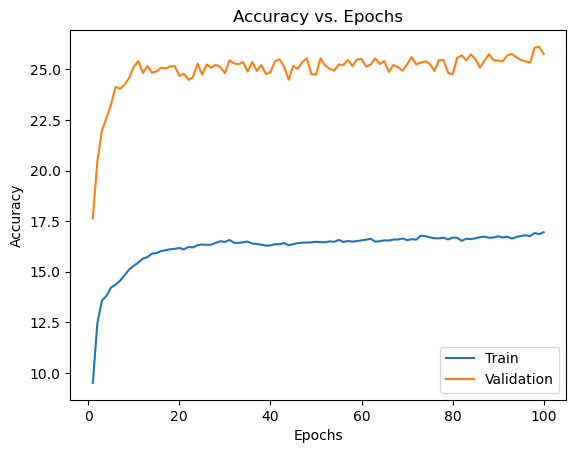

In [17]:
if params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
    )

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/MLP_utils/utils.py:884: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/MLP_utils/utils.py:885: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



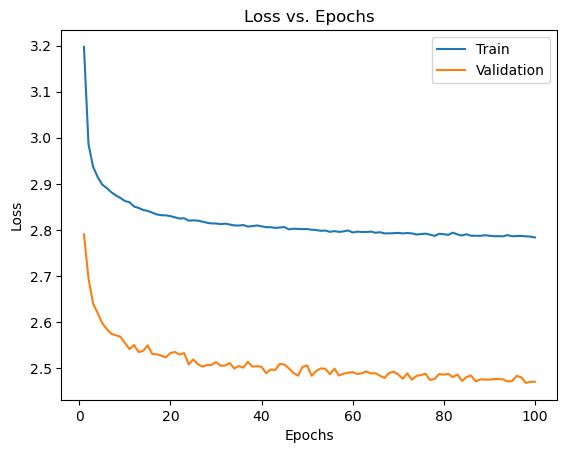

In [18]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
)

In [19]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(model, test_loader, params)
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(model, test_loader, params)
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.12      0.82      0.21      3564
           1       0.00      0.00      0.00      1578
           2       0.30      0.31      0.30      1672
           3       0.00      0.00      0.00      1646
           4       0.10      0.02      0.03      1598
           5       0.37      0.44      0.40      1651
           6       0.16      0.15      0.16      1761
           7       0.00      0.00      0.00      1493
           8       0.00      0.00      0.00      1581
           9       0.76      0.64      0.70      1288
          10       0.14      0.19      0.16      2690
          11       0.40      0.11      0.17      1176
          12       0.67      0.48      0.56      1475
          13       0.00      0.00      0.00      1586
          14       0.00      0.00      0.00      1751
          15       0.00      0.00      0.00      1646
          16       0.00      0.00      0.00      1681
          17       0.16    

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Precision for class 3: 0.0
Recall for class 3: 0.0
Precision for class 4: 0.09764309764309764
Recall for class 4: 0.018147684605757195
Precision for class 5: 0.36736736736736736
Recall for class 5: 0.44457904300423984
Precision for class 6: 0.16492949110974864
Recall for class 6: 0.15275411697898922
Precision for class 7: 0.0
Recall for class 7: 0.0
Precision for class 8: 0.0
Recall for class 8: 0.0


/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Precision for class 9: 0.7644320297951583
Recall for class 9: 0.6374223602484472
Precision for class 10: 0.13764961915125137
Recall for class 10: 0.18810408921933086
Precision for class 11: 0.3968253968253968
Recall for class 11: 0.10629251700680271
Precision for class 12: 0.6701127819548872
Recall for class 12: 0.48338983050847456
Precision for class 13: 0.0
Recall for class 13: 0.0
Precision for class 14: 0.0
Recall for class 14: 0.0


/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Precision for class 15: 0.0
Recall for class 15: 0.0
Precision for class 16: 0.0
Recall for class 16: 0.0
Precision for class 17: 0.15933781686497675
Recall for class 17: 0.18872549019607843


/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Precision for class 18: 0.21157969978556113
Recall for class 18: 0.3661100803957947
Precision for class 19: 0.2608695652173913
Recall for class 19: 0.004098360655737705
Precision for class 20: 0.2918492550394391
Recall for class 20: 0.1989247311827957
Precision for class 21: 0.33099041533546325
Recall for class 21: 0.3239524702939337
Precision for class 22: 0.6082916368834882
Recall for class 22: 0.5246609124537608
Precision for class 23: 0.34628862695125834
Recall for class 23: 0.7548611111111111
Precision for class 24: 0.39228650137741045
Recall for class 24: 0.5737308622078968
Precision for class 25: 0.7348484848484848
Recall for class 25: 0.6037344398340249
Precision for class 26: 0.39690721649484534
Recall for class 26: 0.05641025641025641
Precision for class 27: 0.31900604432505036
Recall for class 27: 0.3233492171545269
Precision for class 28: 0.8072625698324022
Recall for class 28: 0.42251461988304095
Precision for class 29: 0.45494579945799457
Recall for class 29: 0.8027495517

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Precision for class 33: 0.0
Recall for class 33: 0.0
Precision for class 34: 0.0
Recall for class 34: 0.0
Precision for class 35: 0.09848484848484848
Recall for class 35: 0.005434782608695652
36


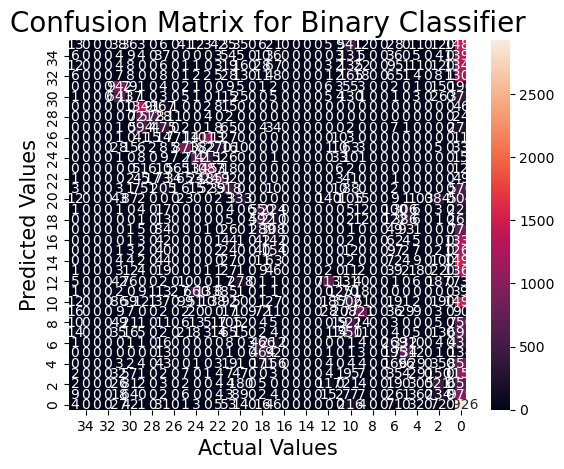

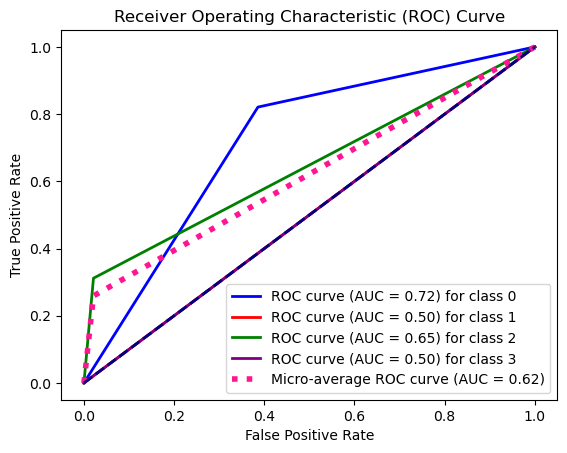

In [20]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    confusion_matrix_df = results_output(y_pred_list, Y_test, params)
elif params.MODEL_TYPE == "Binary_Classification":
    results_output(y_pred_list, Y_test, params, y_pred_prob_list)
else:
    raise Exception("Model type must be specified for proper model testing")